In [ ]:
!pip install tensorflow


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
import zipfile
import os

# Define the path to the ZIP file (if not already defined)
zip_path = '/content/drive/MyDrive/Colab Notebooks/TomatoDataset.zip'

# Extract the contents of the ZIP file
extract_path = '/content/dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the extracted files
print(os.listdir(extract_path))

['TomatoDataset']


In [ ]:
import os
import shutil
import random

# Define paths
dataset_path = '/content/dataset'
train_path = '/content/dataset/train'
val_path = '/content/dataset/validation'

# Create train and validation directories
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

# Define the split ratio (e.g., 80% for training, 20% for validation)
split_ratio = 0.8

# Get the actual image class folders within 'TomatoDataset'
# Updated logic to get subdirectories within 'TomatoDataset'
image_class_folders = [f for f in os.listdir(os.path.join(dataset_path, 'TomatoDataset')) if os.path.isdir(os.path.join(dataset_path, 'TomatoDataset', f))]


# Loop through each class folder
for class_name in image_class_folders:
    class_dir = os.path.join(dataset_path, 'TomatoDataset', class_name) # Updated path

    # Skip non-directory files (shouldn't be necessary after filtering)
    if not os.path.isdir(class_dir):
        continue

    # Create corresponding train and validation subdirectories
    os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_path, class_name), exist_ok=True)

    # Get all image files in the class directory
    images = os.listdir(class_dir)
    random.shuffle(images)  # Shuffle the images randomly

    # Split the images into train and validation sets
    train_images = images[:int(len(images) * split_ratio)]
    val_images = images[int(len(images) * split_ratio):]

    # Copy images to the respective directories
    for img in train_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_path, class_name, img))

    for img in val_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(val_path, class_name, img))

print("Dataset split into train and validation directories.")

Dataset split into train and validation directories.


In [ ]:
# Step 1: Set hyperparameters
batch_size = 32
img_height = 224
img_width = 224
epochs = 20

In [ ]:
# Step 2: Data augmentation and generators
train_dir = 'dataset/train'
validation_dir = 'dataset/validation'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1283 images belonging to 10 classes.
Found 326 images belonging to 10 classes.


In [ ]:
# Step 3: Build transfer learning model (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Step 4: Callbacks for better training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Optional: Class weighting if class imbalance is severe
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_generator.classes),
                                     y=train_generator.classes)
class_weights = dict(enumerate(class_weights))



In [ ]:
# Step 5: Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1423 - loss: 2.6160

41/41 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.1437 - loss: 2.6100 - val_accuracy: 0.3988 - val_loss: 1.7446 - learning_rate: 1.0000e-04
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3062 - loss: 1.9313

41/41 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.3069 - loss: 1.9299 - val_accuracy: 0.5153 - val_loss: 1.4828 - learning_rate: 1.0000e-04
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4200 - loss: 1.7208

41/41 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.4201 - loss: 1.7198 - val_accuracy: 0.5736 - val_loss: 1.3708 - learning_rate: 1.0000e-04
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4581 - loss: 1.5222

41/41 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.4585 - loss: 1.5211 - val_accuracy: 0.6104 - val_loss: 1.2541 - learning_rate: 1.0000e-04
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5134 - loss: 1.3445

41/41 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.5135 - loss: 1.3450 - val_accuracy: 0.6196 - val_loss: 1.1609 - learning_rate: 1.0000e-04
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5580 - loss: 1.2682

41/41 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.5574 - loss: 1.2686 - val_accuracy: 0.6442 - val_loss: 1.0987 - learning_rate: 1.0000e-04
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5612 - loss: 1.2101

41/41 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.5610 - loss: 1.2101 - val_accuracy: 0.6166 - val_loss: 1.0454 - learning_rate: 1.0000e-04
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5568 - loss: 1.2370

41/41 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.5571 - loss: 1.2355 - val_accuracy: 0.6564 - val_loss: 1.0292 - learning_rate: 1.0000e-04
Epoch 9/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5793 - loss: 1.1592

41/41 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.5793 - loss: 1.1588 - val_accuracy: 0.6687 - val_loss: 0.9949 - learning_rate: 1.0000e-04
Epoch 10/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6378 - loss: 1.0137

41/41 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.6372 - loss: 1.0143 - val_accuracy: 0.6626 - val_loss: 0.9924 - learning_rate: 1.0000e-04
Epoch 11/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5744 - loss: 1.0926

41/41 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.5748 - loss: 1.0925 - val_accuracy: 0.6871 - val_loss: 0.9572 - learning_rate: 1.0000e-04
Epoch 12/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6193 - loss: 1.0372

41/41 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.6192 - loss: 1.0364 - val_accuracy: 0.6534 - val_loss: 0.9381 - learning_rate: 1.0000e-04
Epoch 13/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6582 - loss: 0.9013

41/41 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.6581 - loss: 0.9026 - val_accuracy: 0.6718 - val_loss: 0.9085 - learning_rate: 1.0000e-04
Epoch 14/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6493 - loss: 0.9744

41/41 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.6493 - loss: 0.9736 - val_accuracy: 0.6748 - val_loss: 0.8887 - learning_rate: 1.0000e-04
Epoch 15/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6413 - loss: 0.9815

41/41 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.6416 - loss: 0.9802 - val_accuracy: 0.6718 - val_loss: 0.8884 - learning_rate: 1.0000e-04
Epoch 16/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6374 - loss: 0.8648

41/41 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.6378 - loss: 0.8651 - val_accuracy: 0.6963 - val_loss: 0.8643 - learning_rate: 1.0000e-04
Epoch 17/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.6695 - loss: 0.8242 - val_accuracy: 0.6748 - val_loss: 0.8652 - learning_rate: 1.0000e-04
Epoch 18/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6624 - loss: 0.8358

41/41 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.6620 - loss: 0.8368 - val_accuracy: 0.6810 - val_loss: 0.8515 - learning_rate: 1.0000e-04
Epoch 19/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6637 - loss: 0.8473

41/41 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.6638 - loss: 0.8472 - val_accuracy: 0.6840 - val_loss: 0.8417 - learning_rate: 1.0000e-04
Epoch 20/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6751 - loss: 0.8292

41/41 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.6752 - loss: 0.8290 - val_accuracy: 0.6840 - val_loss: 0.8348 - learning_rate: 1.0000e-04


In [ ]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6656 - loss: 0.8680
Validation Accuracy: 68.40%


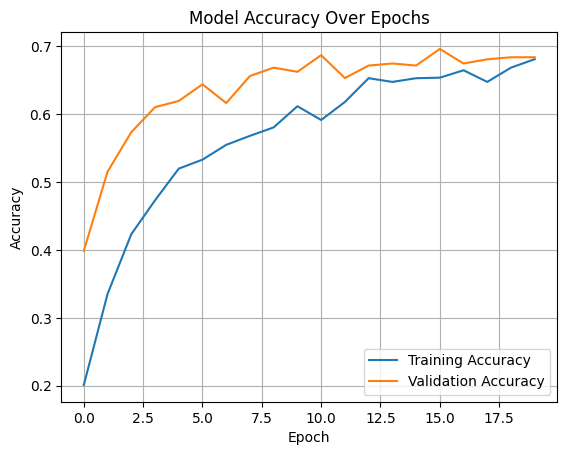

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


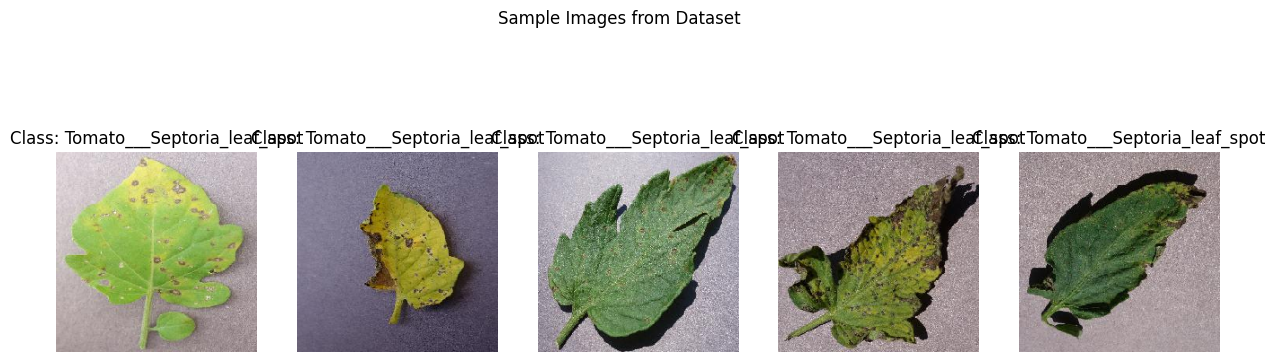

In [ ]:
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define path to one of the training folders (e.g., for one class)
sample_class_dir = os.path.join(train_path, random.choice(os.listdir(train_path)))

# Get random image files from the selected class folder
image_files = random.sample(os.listdir(sample_class_dir), 5)  # display 5 random images

# Plot the images
plt.figure(figsize=(15, 5))
for i, img_file in enumerate(image_files):
    img_path = os.path.join(sample_class_dir, img_file)
    img = load_img(img_path, target_size=(img_height, img_width))
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {os.path.basename(sample_class_dir)}")
    plt.axis('off')
plt.suptitle("Sample Images from Dataset")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


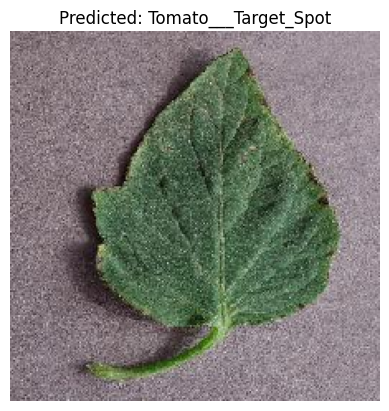

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess your real-time image
img_path = '/content/dataset/TomatoDataset/Tomato___Target_Spot/0b0e5158-180e-487c-b4a7-1ee496473147___Com.G_TgS_FL 9932.JPG'  # 🔁 Change this to your image path
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # normalize just like in training

# Predict the class
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Map the predicted class index to class labels
class_indices = train_generator.class_indices
class_labels = dict((v, k) for k, v in class_indices.items())
predicted_label = class_labels[predicted_class_index]

# Display result
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()
